# Modeling and simulation with partial differential equations
Linnéuniversitetet

Student: Fill in name of all members and student codes.

The purpose of this computer lab is to illustrate approximation methods by using local basis functions in higher dimension. We begin revising the concepts of interpolation and best approximation of functions in this basis. consecutively, we present the approximation of solutions to some Partial Differential Equations (PDE) by using the Finite Element Method (FEM). The last part of the computer lab deals with a time dependent PDE.

The student is expected to present solutions to all exercises in the notebook and motivate answers by showing derivations in detail and submitting Python scripts.

You are required to submit solutions to all the exercises presented in this notebook. The deadline for hand in your solutions is **Friday October 20th**.


## Computer lab 5: FEM in 2D

In this computer Lab we make use of meshes consisting of triangles for the approximation to solutions of PDEs.
We get familiar with the concepts presented in the Lectures by first visualizing the mesh and it's properties. 
For this, the definition of rectangular meshes and plotting routines are imported from the file `meshtools.py` and `plottools.py` that should be placed in the same directory as this notebook.

In the script below we generate a mesh and plot a useful sketch where we can visualize information about points, and elements of the triangulation. In the plot we show boundary nodes in green and interior nodes in red. Additionally, the corresponding indexing for each node is added to the plot. Similarly, the indexing for the elements (triangles) is presented after the symbol #. The function `on_dirichlet_boundary` defines a criteria to select those nodes that are on the boundary.

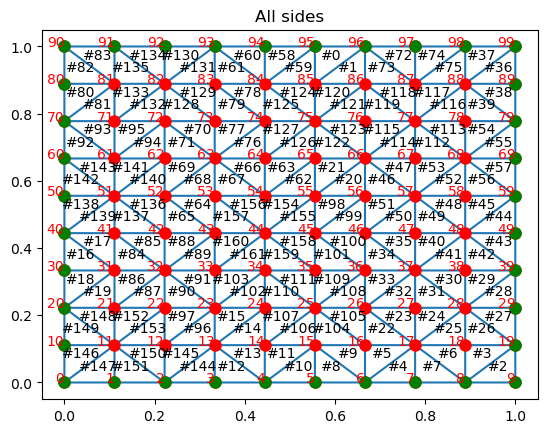

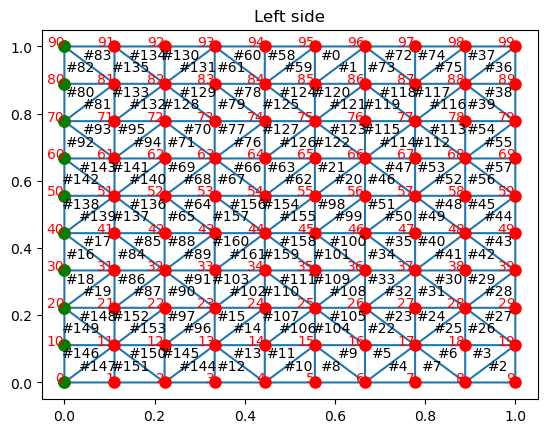

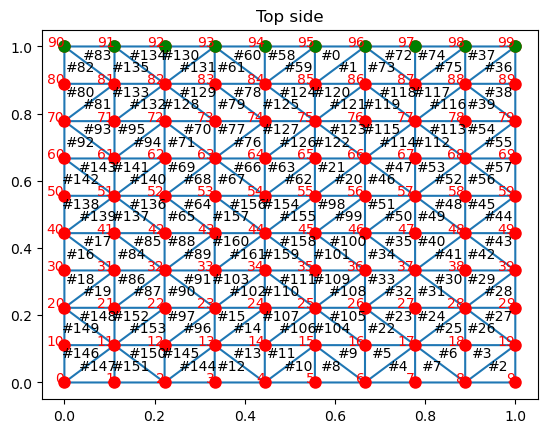

In [1]:
import numpy as np
from math import ceil

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
# %matplotlib widget

import scipy.sparse as sp
from scipy.sparse import identity, dok_matrix, spdiags
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import factorized

import meshtools as mt
import plottools as pt

def extract_nodes(P, inside_domain, Lx=1, Ly=1):
    """Short function which extract all node indices i
    for which the inside_domain(P[i]) evaluates to True.
    """
    return [ i for i in range(P.shape[0]) if inside_domain(P[i], Lx, Ly) ]

def on_dirichlet_boundary(x, Lx=1, Ly=1):
    eps = 1e-12
    return  (x[0] < eps or np.abs(x[0]-Lx) < eps or
             x[1] < eps or np.abs(x[1]-Ly) < eps)
    
def on_dirichlet_boundary_left(x, Lx=1, Ly=1):
    eps = 1e-12
    return  (x[0] < eps)

def on_dirichlet_boundary_top(x, Lx=1, Ly=1):
    eps = 1e-12
    return  (np.abs(x[1]-Ly) < eps)


# Define number of subdivision in each spatial direction
Nx = 9
Ny = 9

# Length of the interval 
Lx = 1.0
Ly = 1.0


# Mesh and coordinates
P, T, edges = mt.rectangle_tria ((0,0), (Lx,Ly), Nx, Ny)

X = P[:, 0]
Y = P[:, 1]

# Extract Dirichlet nodes
boundary_nodes  = extract_nodes(P, on_dirichlet_boundary, Lx, Ly)
left_boundary_nodes = extract_nodes(P, on_dirichlet_boundary_left, Lx, Ly)
top_boundary_nodes = extract_nodes(P, on_dirichlet_boundary_top, Lx, Ly)

# Plot mesh including boundary nodes
pt.plot_mesh_2d(P, T, boundary_nodes, 'All sides')
pt.plot_mesh_2d(P, T, left_boundary_nodes, 'Left side')
pt.plot_mesh_2d(P, T, top_boundary_nodes, 'Top side')


### Exercise 1: 
Get familiar with the mesh:

**1)** Experiment with the mesh by modifying the values Lx, Nx, Ly and Ny.

**2)** Modify `on_dirichlet_boundary` such that only nodes on the left face are extracted and plot the resulting mesh.

**3)** Modify `on_dirichlet_boundary` such that only nodes on the top face are extracted and plot the resulting mesh.

### Local basis functions

The next task consist of defining local basis functions in the way presented in the lectures.
We choose linear functions defined in each triangle in a standard way. Then, Hat functions $\varphi_i(x,y)$ are constructed as a piecewise linear functions.

In the script below we visualize a hat function $\varphi_i(x,y)$ of given index.

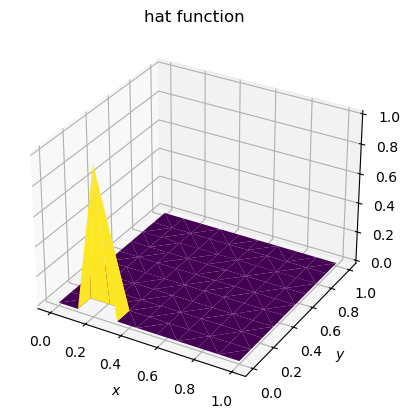

In [2]:
index=2

Np = P.shape[0]

U=np.zeros(Np)
U[index]=1.0

pt.plot2D(X, Y, U, triangles=T, title="hat function")


### Exercise 2:
The output sketch for the mesh in **Ex 1**, provides the indexing of the triangulation. Use this data for producing the plots of hat functions corresponding to a node:

**1)** in the interior of the domain and

**2)** on the boundary.

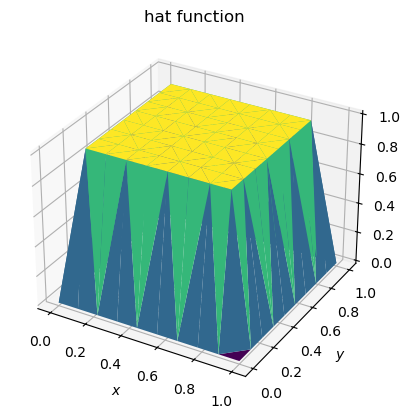

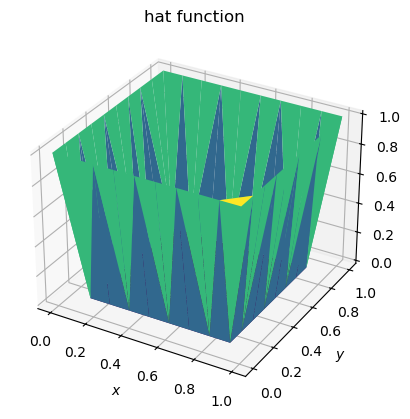

In [3]:
# ... your solution ...
# Plot inside nodes
boundary_nodes  = extract_nodes(P, on_dirichlet_boundary, Lx, Ly)

inside_nodes  = [i for i in range((Nx+1)*(Ny+1)) if i not in boundary_nodes]

Np = P.shape[0]

U=np.zeros(Np)
U[inside_nodes]=1.0

pt.plot2D(X, Y, U, triangles=T, title="hat function")

# Plot boundary nodes
Np = P.shape[0]

U=np.zeros(Np)
U[boundary_nodes]=1.0

pt.plot2D(X, Y, U, triangles=T, title="hat function")

### Exercise 3:

**1)** Choose $N_1=(0,0)$, $N_2=(4,0)$ and $N_3=(0,2)$. Derive explicit expressions for $\varphi_i(x,y),\,\,i=1,2,3$ defined in the element $K$ corresponding to the triangle containing the nodes $N_1,N_2,N_3$.

**2)** Prove that $\varphi_1(x,y)+\varphi_2(x,y)+\varphi_3(x,y)=1$ for all $(x,y)\in K$.

**3)** By using the formulas provided in the course lectures compute the following integrals:
$$a)\,\,\int_K \varphi_1\varphi_1\,dx,\,\,\,\,b)\,\,\int_K \varphi_2\varphi_3\,dx,\,\,\,\,c)\,\,\int_K \nabla\varphi_1\cdot\nabla\varphi_1\,dx,\,\,\,\,d)\,\,\int_K \nabla\varphi_2\cdot\nabla\varphi_3\,dx.$$

your solution ...

## Interpolation:
As we have seen in the lectures, the interpolant $\tilde f$ of a function $f(x)$ can be defined as
$$\tilde f(x)=\sum_j f(x_j)\varphi_j(x),\,\,\,\text{with}\,\,\,x,x_j\in\mathbb R^2,$$
where we use our local basis functions $\varphi_j(x)$ and 
assign the function values at nodal points $x_j$ in our mesh.

In the next script we visualize the interpolation of a Gaussian function over our mesh.
You can improve the quality of the interpolant $\tilde f$ by remeshing by using larger values of `Nx` and `Ny`.

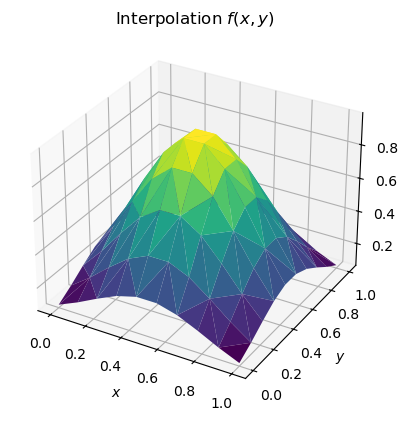

In [4]:
# Right hand side
def f(x, y, Lx=1, Ly=1):
    return np.exp(-5.0*((x-Lx/2)**2 + (y-Ly/2)**2) )

F=f(X,Y,Lx,Ly)

pt.plot2D(X, Y, F, triangles=T, title="Interpolation $f(x,y)$")

## L2-Projection (Best approximation):

The best approximation $P_h f$ of a function $f(x,y)$ satisfies the orthogonality condition 
$$\int_\Omega (P_h f-f)v\,dx=0,$$
for functions $v$ used in the representation of $P_hf$.

We can compute the best approximation $P_h f$ given the local basis functions $\varphi_i(x,y)$, by setting
$$P_h f:=\sum_j \xi_j\varphi_j,\,\,\,\text{and}\,\,\,v=\varphi_i,$$
and employing the orthogonality condition to derive a system of equations for the coefficients $\xi_j.$

The computation requires the assembly of the mass matrix $M$ and load vector $b$. Their entries are defined as
$$M_{ij}=\int_\Omega \varphi_j\varphi_i\,dx,\,\,\,\text{}\,\,\,b_i=\int_\Omega f \varphi_i\,dx.$$


In the code below we provide such definitions. Study the code and compare the implementation against the formulas provided in the lectures. Notice the use of `np.ix_(l2g, l2g)` which allows a convienient way of performing local to global assembly.

In [5]:
def assemble_mass_matrix(P, T):
    # 2 times the mass matrix on a unit triangle
    M_ref = 1.0/12.0*np.array([[2, 1, 1],
                               [1, 2, 1],
                               [1, 1, 2]])
    # Create matrix
    n_p = P.shape[0]
    print("Create mass matrix of size %d x %d" % (n_p, n_p))
    M = dok_matrix((n_p, n_p))
    
    # Iterate over all triangles
    n_t = T.shape[0]
    print("Assemble mass matrix over %d elements ..." % n_t)
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[l2g] # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        area=abs(0.5*np.cross(N1-N0,N2-N0))
        M_K = M_ref*area
        M[np.ix_(l2g, l2g)] += M_K
    
    return M

def assemble_load_vector(P, T, f, qr="midpoint_2d"):
    # Create and intialize vector
    n_p = P.shape[0]
    # print("Create load vector of size %d " % n_p)
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    n_t = T.shape[0]
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[l2g] # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        area=abs(0.5*np.cross(N1-N0,N2-N0))
        
        if qr == "midpoint_2d":
            # 2d Midpoint rule
            mp =  0.5*np.array([N0+N1, N1+N2, N2+N0])
            b_K = area/3*0.5*np.array([f(mp[i-1,0], mp[i-1,1]) + f(mp[i,0], mp[i,1]) for i in range(0,3)])  
            # Fall back to corner point quadrature rule
        else:
            b_K = f(tri[:,0], tri[:,1])*area/3

        b[np.ix_(l2g)] += b_K
    return b

In the script below we compute the best approximation when piecewise linear basis functions are used.
Particularly, we compute the best approximation $P_h f$ to the same function as used in the **interpolant** $\tilde f$. We perform the assembly and consecutively we solve the system of equations and plot the resulting $P_h f$. 

Create mass matrix of size 100 x 100
Assemble mass matrix over 162 elements ...


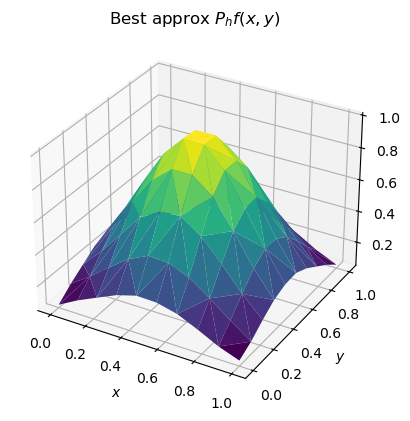

In [6]:
from scipy.sparse.linalg import spsolve

# Compute mass matrix
M = assemble_mass_matrix(P, T)
b = assemble_load_vector(P, T, f)

M = M.tocsr() # Converting in CSR sparse format

U=spsolve(M, b)

pt.plot2D(X, Y, U, triangles=T, title="Best approx $P_hf(x,y)$")

### Exercise 4:
We test our implementation by refining the mesh. For this, provide plots for the interpolation and the best approximation of the following function:
$$f(x,y)=\sin(3\pi x) \exp(-5(y-L_y/2)^2)$$
by using Nx=Ny=N, with N=5,10,20.

Create mass matrix of size 36 x 36
Assemble mass matrix over 50 elements ...


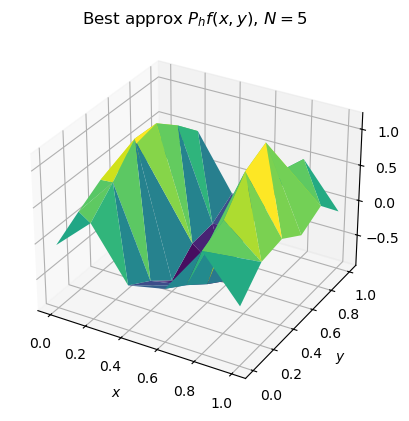

Create mass matrix of size 121 x 121
Assemble mass matrix over 200 elements ...


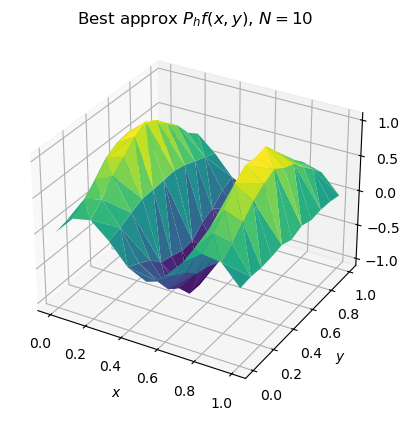

Create mass matrix of size 441 x 441
Assemble mass matrix over 800 elements ...


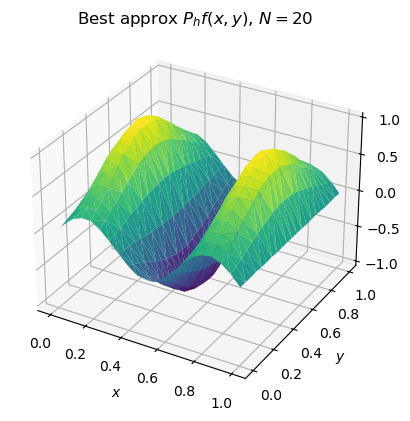

In [7]:
# ... your solution

def g(x, y, Lx=1, Ly=1):
    return np.sin(3*np.pi*x)*np.exp(-5*(y-Ly/2)**2)

n = [5, 10, 20]

for N in n:
    Nx, Ny = N, N

    # Mesh and coordinates
    P, T, edges = mt.rectangle_tria ((0,0), (Lx,Ly), Nx, Ny)

    X = P[:, 0]
    Y = P[:, 1]
    
    # Compute mass matrix
    M = assemble_mass_matrix(P, T)
    b = assemble_load_vector(P, T, g)

    M = M.tocsr() # Converting in CSR sparse format

    U=spsolve(M, b)

    pt.plot2D(X, Y, U, triangles=T, title=f"Best approx $P_hf(x,y)$, $N={N}$")

## Finite Element Method for BVPs

Now we turn into the approximation to solutions of Partial Differential Equations (PDE) by using the Finite Element Method.

For this task we are required to have available a variational formulation to the PDE at hand.
Several of the PDEs that we have introduced in this course contain the Laplace operator or "Laplacian". 
After integration by parts (Green's identity) we are required to compute the stiffness matrix $A$ with entries
$$A_{ij}=\int_\Omega \nabla\varphi_j\cdot\nabla\varphi_j\,dx.$$


Study the implementation below and compare the used formulas against the notes provided in the lectures. 

In [8]:
def compute_hat_gradients(tri):
    # Compute area
    N0, N1, N2 = tri
    area=abs(0.5*np.cross(N1-N0, N2-N0))

    # Compute b = (1,1,1) x (x_2^1,x_2^2,x_2^3). c is similar
    ones = np.ones(3)
    b = np.cross(tri[:,1], ones)/(2.*area)
    c = np.cross(ones, tri[:,0])/(2.*area)

    return (area, b, c)

def assemble_stiffness_matrix(P, T):
    # Create matrix
    n_p = P.shape[0]

    print("Create stiffness matrix of size %d x %d" % (n_p, n_p))
    A = dok_matrix((n_p, n_p))
    
    # Iterate over all triangles
    n_t = T.shape[0]

    print("Assemble stiffness matrix over %d elements ..." % n_t)
    for K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[l2g] # Get triangle coordinates
        
        # TODO: Add computation of abar!
        area, b, c = compute_hat_gradients(tri)

        # Local element matrix
        A_K = (np.outer(b, b) + np.outer(c, c))*area
        A[np.ix_(l2g, l2g)] += A_K

    print("Done.")   
    return A

### Poisson problem of Dirichlet type
We now use the developed machinery in order to obtain a FE approximation to the solution of the following Poisson problem
$$
\begin{array}{rl}
-\Delta u=f, & x\in \Omega \\
u=g, & x\in \partial \Omega
\end{array}
$$
with $\Omega:=[0,1]^2$. 

### Exercise 5:
**1)** Derive a variational formulation and Finite Element Method for the Poisson problem presented above.

**2)** Discretize the Poisson problem: derive a system of equations resulting from your FEM.

Hint: write down the resulting system of equations by introducing the $\varphi_i$ and the FE representation.

### FEM implementation for the Poisson problem of Dirichlet type:
In the script below we present a simple code that implements a FE discretization for Poisson problems. 

Particularly we use  
$$f(x,y)=x\,\,\,\text{and}\,\,\,
g(y)=\left\{
\begin{array}{rl}
\sin(\pi y), & x=0\\
0, & \text{otherwise}
\end{array}
\right.
.
$$

We refer to the solution of this Poisson problem later in **Ex 8**.

Pay particular attention to how Dirichlet boundary conditions are imposed in the resulting linear system. Make sure that you understand what has been done and confront it with the lecture notes.

Create stiffness matrix of size 121 x 121
Assemble stiffness matrix over 200 elements ...
Done.
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 21, 22, 32, 33, 43, 44, 54, 55, 65, 66, 76, 77, 87, 88, 98, 99, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]


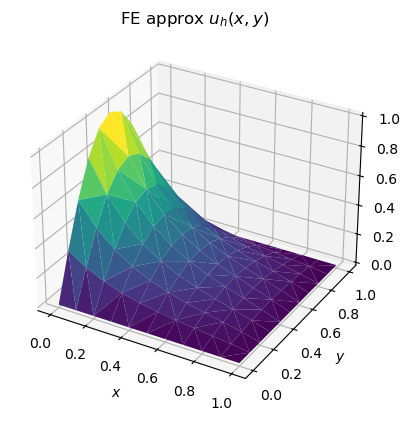

In [9]:
# Right hand side
def f(x, y):
    return x

def g(x,y):
    fun=0.0
    if x==0:
        fun=np.sin(np.pi*y)
    
    return fun

Nx = 10
Ny = 10

# Length of the interval 
Lx = 1.0
Ly = 1.0

# Mesh and coordinates
P, T, edges = mt.rectangle_tria ((0,0), (Lx,Ly), Nx, Ny)

Np = P.shape[0]

X = P[:, 0]
Y = P[:, 1]

# Compute A_h (only needed once!)
A = assemble_stiffness_matrix(P, T)
b = assemble_load_vector(P, T, f)

#def dirichlet_boundary_minus_right_face(x):
#    eps = 1e-12
#    return  (...)

# Extract Dirichlet nodes
dirichlet_nodes  = extract_nodes(P, on_dirichlet_boundary) # dirichlet_boundary_minus_right_face

print(dirichlet_nodes)

# Apply Dirichlet boundary conditions to the linear system
Nd = len(dirichlet_nodes)

for j in range(Nd):
    xj=P[dirichlet_nodes[j],0]
    yj=P[dirichlet_nodes[j],1]
    for i in range(Np):
        b[i] -= A[i,dirichlet_nodes[j]]*g(xj,yj)
        A[i,dirichlet_nodes[j]] = 0.0
        A[dirichlet_nodes[j],i] = 0.0
    A[dirichlet_nodes[j],dirichlet_nodes[j]] = 1.0
    b[dirichlet_nodes[j]] = g(xj,yj)
    
A = A.tocsr() # Converting in CSR sparse format

U=spsolve(A, b)

pt.plot2D(X, Y, U, triangles=T, title="FE approx $u_h(x,y)$")


### Exercise 6:
We now compute a FE approximation to the solution of the following Poisson problem
$$
\begin{array}{rl}
-\Delta u=f, & x\in \Omega \\
u=0, & x\in \Gamma_D \\
\mathbf n\cdot\nabla u=0, & x\in \Gamma_N, \\
\end{array}
$$
where $f(x,y)=x$. Moreover, let $\Gamma_D$ be the set consisting of all points belonging to all faces of $\Omega:=[0,1]^2$ except of the right face and $\Gamma_N$ be the set of all points belonging to the right face of $\Omega$. Then, we have $\partial \Omega=\Gamma_D\cup\Gamma_N$. 

**1)** Modify the code above such that Dirichlet boundary conditions are applied on $\Gamma_D$ and Neumann boundary conditions are applied on $\Gamma_N$. For this define a new function `dirichlet_boundary_minus_right_face` that labels nodes satisfying this criteria.

**2)** Compute the resulting FE approximation and provide a plot with your result.

... your solution ...

Dirichlet nodes: 31, Neumann edges: 10
Create stiffness matrix of size 121 x 121
Assemble stiffness matrix over 200 elements ...
Done.


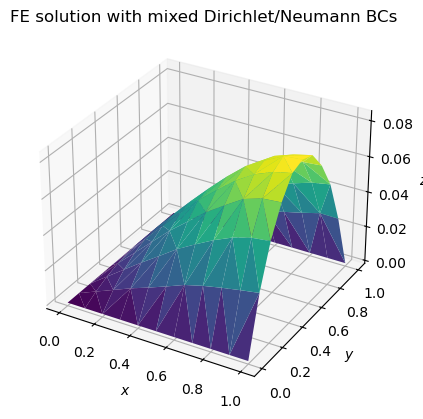

In [17]:
# Right hand side functions
def f(x, y):
    return x

# Dirichlet boundary function
def g_dirichlet(x, y):
    return 0

# Neumann boundary function
def g_neumann(x, y):
    return 0

# Dirichlet boundary nodes
def dirichlet_boundary_minus_right_face(x, Lx=1, Ly=1):
    eps = 1e-12
    return  (x[0] < eps or
             x[1] < eps or np.abs(x[1]-Ly) < eps)

def neumann_boundary(x):
    eps = 1e-12
    return (abs(x[0] - 1) < eps)

def extract_neumann_edges(points, edges, on_neumann_boundary):
    """Extract edges where Neumann BCs are applied"""
    neumann_edges = []
    for edge in edges:
        # Check if both endpoints are on Neumann boundary
        p1 = points[edge[0]]
        p2 = points[edge[1]]
        if on_neumann_boundary(p1) and on_neumann_boundary(p2):
            neumann_edges.append(edge)
    return neumann_edges

def assemble_load_vector_with_neumann(P, T, f, neumann_edges, g_neumann, qr="midpoint_2d"):
    """Assemble load vector with both volume and Neumann boundary integrals"""
    # Create and intialize vector
    n_p = P.shape[0]
    # print("Create load vector of size %d " % n_p)
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    n_t = T.shape[0]
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[l2g] # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        area=abs(0.5*np.cross(N1-N0,N2-N0))
        
        if qr == "midpoint_2d":
            # 2d Midpoint rule
            mp =  0.5*np.array([N0+N1, N1+N2, N2+N0])
            b_K = area/3*0.5*np.array([f(mp[i-1,0], mp[i-1,1]) + f(mp[i,0], mp[i,1]) for i in range(0,3)])  
            # Fall back to corner point quadrature rule
        else:
            b_K = f(tri[:,0], tri[:,1])*area/3

        b[np.ix_(l2g)] += b_K
    
    # Neumann boundary integral
    for edge in neumann_edges:
        node1, node2 = edge
        p1, p2 = P[node1], P[node2]
        
        # Edge length
        length = np.linalg.norm(p2 - p1)
        
        # Midpoint for evaluating Neumann function
        mid_point = 0.5 * (p1 + p2)
        g_val = g_neumann(mid_point[0], mid_point[1])
        
        # Add contributions (linear basis functions on edge)
        b[node1] += 0.5 * length * g_val
        b[node2] += 0.5 * length * g_val
    
    return b

# Mesh generation (same as before)
Nx = 10; Ny = 10
Lx = 1.0; Ly = 1.0
P, T, edges = mt.rectangle_tria((0,0), (Lx,Ly), Nx, Ny)
Np = P.shape[0]

# Extract boundary information
dirichlet_nodes = extract_nodes(P, dirichlet_boundary_minus_right_face)
neumann_edges = extract_neumann_edges(P, edges, neumann_boundary)

print(f"Dirichlet nodes: {len(dirichlet_nodes)}, Neumann edges: {len(neumann_edges)}")

A = assemble_stiffness_matrix(P, T)
# Assemble load vector with Neumann contributions
b = assemble_load_vector_with_neumann(P, T, f, neumann_edges, g_neumann)

for j in range(len(dirichlet_nodes)):
    xj=P[dirichlet_nodes[j],0]
    yj=P[dirichlet_nodes[j],1]
    for i in range(Np):
        b[i] -= A[i,dirichlet_nodes[j]]*g_dirichlet(xj,yj)
        A[i,dirichlet_nodes[j]] = 0.0
        A[dirichlet_nodes[j],i] = 0.0
    A[dirichlet_nodes[j],dirichlet_nodes[j]] = 1.0
    b[dirichlet_nodes[j]] = g_dirichlet(xj,yj)

A = A.tocsr()
U = spsolve(A, b)

pt.plot2D(P[:, 0], P[:, 1], U, triangles=T, 
          title="FE solution with mixed Dirichlet/Neumann BCs")

### Exercise 7:
We now use compute a FE approximation to the solution of the following PDE
$$
\begin{array}{rl}
-\Delta u+cu=f, & x\in \Omega \\
u=0, & x\in \Gamma_D \\
\mathbf n\cdot\nabla u=0, & x\in \Gamma_N, \\
\end{array}
$$
where $f(x,y)=x$. Let $\Gamma_D$ and $\Gamma_N$ be the same sets defined in **Ex 6**.

**1)** Write down the variational formulation of this problem and the FEM. Finally, write down the resulting system of equations by introducing the $\varphi_i$ and the FE representation.

**2)** By modifying the code above, compute the resulting FE solutions to this PDE for each of the cases $c=1,20,100$ and provide plots with your results.
Hint: Define a new system matrix $S=A+cM$ and modify your code such that Dirichlet bounday conditions are applied to $S$ instead of $A$.

Dirichlet nodes: 31, Neumann edges: 10
Create stiffness matrix of size 121 x 121
Assemble stiffness matrix over 200 elements ...
Done.
Create mass matrix of size 121 x 121
Assemble mass matrix over 200 elements ...


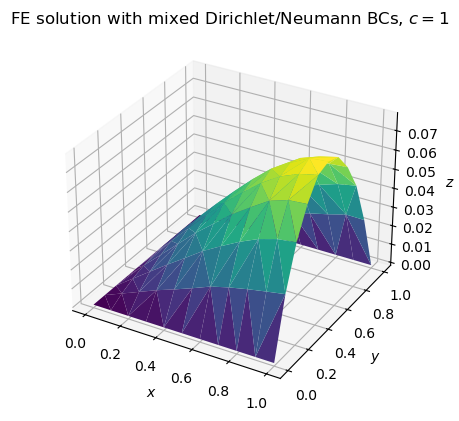

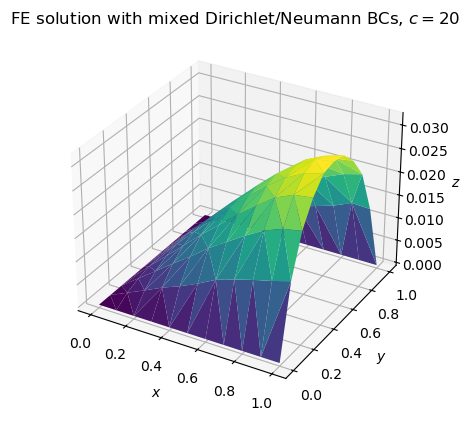

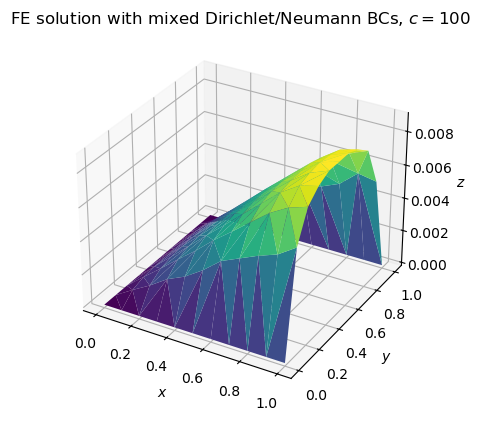

In [25]:
# ... your solution

# Mesh generation (same as before)
Nx = 10; Ny = 10
Lx = 1.0; Ly = 1.0
P, T, edges = mt.rectangle_tria((0,0), (Lx,Ly), Nx, Ny)
Np = P.shape[0]

# Extract boundary information
dirichlet_nodes = extract_nodes(P, dirichlet_boundary_minus_right_face)
neumann_edges = extract_neumann_edges(P, edges, neumann_boundary)

print(f"Dirichlet nodes: {len(dirichlet_nodes)}, Neumann edges: {len(neumann_edges)}")

c = [1, 20, 100]
A = assemble_stiffness_matrix(P, T)
M = assemble_mass_matrix(P, T)

for C in c:
    S = A + C*M
    # Assemble load vector with Neumann contributions
    b = assemble_load_vector_with_neumann(P, T, f, neumann_edges, g_neumann)

    for j in range(len(dirichlet_nodes)):
        xj=P[dirichlet_nodes[j],0]
        yj=P[dirichlet_nodes[j],1]
        for i in range(Np):
            b[i] -= S[i,dirichlet_nodes[j]]*g_dirichlet(xj,yj)
            S[i,dirichlet_nodes[j]] = 0.0
            S[dirichlet_nodes[j],i] = 0.0
        S[dirichlet_nodes[j],dirichlet_nodes[j]] = 1.0
        b[dirichlet_nodes[j]] = g_dirichlet(xj,yj)

    S = S.tocsr()
    U = spsolve(S, b)

    pt.plot2D(P[:, 0], P[:, 1], U, triangles=T, 
            title=f"FE solution with mixed Dirichlet/Neumann BCs, $c={C}$")

# Heat equation

We now illustrate a simple scheme to compute a FE approximation to the solution of the following PDE
$$
\begin{array}{rll}
-\Delta u+\frac{\partial u}{\partial t}=&\!\!\!\!f, & x\in \Omega,\,\,\,t\in(0,T] \\
u(x,0)=&\!\!\!\!u_0(x), & x\in \Omega,\,\,\,t=0 \\
u(x,t)=&\!\!\!\!0, & x\in \Gamma
\end{array}
$$
where $f(x,t)$ is a given function. Let $\Gamma$ be the boundary of the rectangle consisting of all its edges.

The assumption of steady state implies $\dot u=0$. Notice that under this assumption
the presented heat equation becomes the **Poisson problem of Dirichlet type**.

### Exercise 8:

**2)** Write down the variational formulation of the heat equation problem and the corresponding FEM. 

**2)** Derive the resulting system of ordinary differential equations by introducing the $\varphi_i$ and the FE representation
$$u(x,t)=\sum_j \xi_j(t)\varphi_j(x).$$

Hint: The system of equations should have the form $M\dot \xi(t)+A\xi(t)=b(t)$.

### Discretization in time:

We now choose to discretize in time. For this we introduce the following uniform partition in time: $t^n=n\Delta t$ and $\xi^n=\xi(t^n)$ with $n=1,2,\ldots,N_t$ and $\Delta t=T/N_t$. We aim to derive a time evolution scheme for obtaining FE nodal vector $\xi^{n+1}$ corresponding to time $t=t^{n+1}$, once we know the FE vector $\xi^{n}$ and load vector $b^{n}$ corresponding to time $t=t^{n}$.

The time discretization used in this task is performed by using the so-called $\theta$-methods. The method consists in approximating time derivatives with the following formula:

$$\frac{u^{n+1}-u^{n}}{\Delta t}\approx  (1-\theta)F(u^n,t^n)+\theta F(u^{n+1},t^{n+1}),\quad \theta\in [0,1],$$
where we follow the notation introduced in **Lecture 14**.

Notice that, in this scheme, $\theta=0$ corresponds to *Forward Euler*, $\theta=1$ to *Backward Euler* and $\theta=1/2$ to *Crank-Nicolson* methods.

### Exercise 9 :
Employ the $\theta$-method described above to discretize the resulting system of ODEs arising from **Ex 8**.
Write down an evolution scheme that allows to compute the vector $\xi^{n+1}$ once we have computed $\xi^{n}$.

### FEM implementation for the Heat equation:
In the script below we present a simple code that performs discretization in space by using FE and discretization in time by employing the $\theta$-method. Study the script and confront it with the lecture notes.

In [26]:
# Initial condition
# Right hand side
def f(x, y, t):
    return x #0*np.ones_like(x)

def u_0(x, y):
    return np.ones_like(x)

# Boundary condition
def g_D(x, y):
    
    fun=0.0*np.ones_like(x)
    for i in range(len(x)):
        if x[i]==0:
            fun[i]=np.sin(np.pi*y[i])
    return fun

def apply_bcs_to_A(A, dirichlet_nodes):
    # Incorporate boundary conditions in matrix A
    # Set all rows corresponding to Dirichlet nodes to 0
    A[dirichlet_nodes, :] = 0 
    
    # Set diagonal to one
    A[dirichlet_nodes, dirichlet_nodes] = 1

def apply_bcs_to_b(b, g_D_values, dirichlet_nodes):
    # Incorporate boundary condition in vector b
    b[dirichlet_nodes] = g_D_values

We now put all the pieces together:

In [13]:
# Start/end time
t0, T = 0, 1

# Define number of subdivision in each spatial direction
N = 10

L=Lx

# Mesh size
h = L/N

# Mesh and coordinates
P, T = mt.rectangle_mesh((0,0), (L,L), N, N)
X = P[:, 0]
Y = P[:, 1]

# Theta 
theta = 1.
bartheta = 1 - theta

# Chose safe dt according to CFL condition
dt = h*h
Nt = ceil(((T - t0)/dt))

# Number of time steps
print("tau = %e" % dt)
print("resulting in %d time steps." % int(Nt))

# Compute mass matrix
M = assemble_mass_matrix(P, T)

# Compute A_h (only needed once!)
A = assemble_stiffness_matrix(P, T)

# Compute total matrix for lhs
A_tot = M + dt*theta*A

# Compute total matrix for rhs
B_tot = M - dt*bartheta*A

# Extract Dirichlet nodes (we do this so early for visual check)
dirichlet_nodes  = extract_nodes(P, on_dirichlet_boundary)

if N < 11:
    # Plot mesh including dirichlet nodes
    pt.plot_mesh_2d(P, T, dirichlet_nodes)

# Adjust rows associated with Dirchlet bc
apply_bcs_to_A(A_tot, dirichlet_nodes) 

A_tot = A_tot.tocsc()

# Precompute LU factorization
solve = factorized(A_tot)

# Current time and time step
t, k = t0, 0

# Interpolation (Works only this way since we have a row wise
# numbering of the nodes!
U = u_0(X, Y)
# pt.plot2D(X, Y, U, triangles=triangles, title="Initial value $U^0$")

U = U.ravel()

# Store U for animation plot
U_list = [ U ]

# Start time stepping 
while t < T:

    # New time and time step
    t += dt
    k += 1
    # print("Solving for time step k=%d and time t=%e" %(k,t))

    # Compute right hand side action on U
    U = B_tot.dot(U)

    # Define f at theta midpoint  (otherwise assemble two load vectors)
    f_theta = lambda x,y : f(x,y, t-bartheta*dt)
    b = assemble_load_vector(P, T, f_theta)
    U += dt*b

    # Extract coordinates associated with Dirichlet nodes
    X_dc = X[dirichlet_nodes]
    Y_dc = Y[dirichlet_nodes]

    # Evaluate g at boundary nodes and 
    g_D_values = g_D(X_dc, Y_dc)

    # Apply Dirichlet boundary condition to linear system
    apply_bcs_to_b(U, g_D_values, dirichlet_nodes)

    #Solve system 
    U = solve(U)

    # Store for plotting
    U_list.append(U.copy())

#pt.plot_2D_animation(X, Y, U_list, triangles=triangles)
ani = pt.plot_2D_animation_fem(X, Y, U_list, 
                         triangles=T, 
                         title="My cool solution animation",
                         duration=10)
    

TypeError: only length-1 arrays can be converted to Python scalars

### Exercise 10:
In this exercise we briefly illustrate the stability of Finite Differences Methods for discretizing the resulting system of ODEs in time.

**1)** Set `N=10` and run the code for the cases: `theta=0` (Forward Euler), `theta=0.5` (Crank-Nicolson) and `theta=1` (Backward Euler) and describe your observations. Hint: motivate your answer by discussing the stability properties of each method.

**2)** Compare the converged $u$ (solution after a long time) with the solution to the solution plotted in the **FEM implementation for a Poisson problem of Dirichlet type**.

**3)** Using `dt` larger than the original given value (`dt=0.5*h*h`), which method seems to be stable?

**4)** For the method that is unstable try to find the smallest constant `c` such that the method becomes stable when using `dt=c*h*h`.